## Prophet Model

https://nbviewer.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
input_file = "../data/processed/ep/merged_with_holidays.parquet"

data_df = pd.read_parquet(input_file)

In [3]:
# set wait times from January to March to 0
data_df.loc[
    (data_df["timestamp"].dt.month == 1)
    | (data_df["timestamp"].dt.month == 2)
    | (data_df["timestamp"].dt.month == 3),
    "wait_time",
] = 0

In [4]:
ride_name = "silver star"
ride_df = data_df.loc[data_df["ride_name"] == ride_name]
ride_df = ride_df.reset_index(drop=True)

ride_df

,ride_name,timestamp,wait_time,closed,temperature,rain,wind,is_german_holiday,is_swiss_holiday,is_french_holiday
0,silver star,2017-05-23 09:00:00,0.0,False,18.7,0.0,1.1,False,False,False
1,silver star,2017-05-23 09:05:00,NaN,False,18.7,0.0,1.1,False,False,False
2,silver star,2017-05-23 09:10:00,1.0,False,18.7,0.0,1.1,False,False,False
3,silver star,2017-05-23 09:15:00,NaN,False,18.7,0.0,1.1,False,False,False
4,silver star,2017-05-23 09:20:00,10.0,False,18.7,0.0,1.1,False,False,False
...,...,...,...,...,...,...,...,...,...,...
403095,silver star,2024-12-31 20:40:00,0.0,True,NaN,NaN,NaN,False,False,False
403096,silver star,2024-12-31 20:45:00,0.0,True,NaN,NaN,NaN,False,False,False
403097,silver star,2024-12-31 20:50:00,0.0,True,NaN,NaN,NaN,False,False,False
403098,silver star,2024-12-31 20:55:00,0.0,True,NaN,NaN,NaN,False,False,False


In [5]:
# resample from every 5 minutes to every 30 minutes
ride_df = ride_df.set_index("timestamp").resample("30min").ffill().reset_index()
ride_df

,timestamp,ride_name,wait_time,closed,temperature,rain,wind,is_german_holiday,is_swiss_holiday,is_french_holiday
0,2017-05-23 09:00:00,silver star,0.0,False,18.7,0.0,1.1,False,False,False
1,2017-05-23 09:30:00,silver star,10.0,False,18.7,0.0,1.1,False,False,False
2,2017-05-23 10:00:00,silver star,10.0,False,21.5,0.0,0.7,False,False,False
3,2017-05-23 10:30:00,silver star,25.0,False,21.5,0.0,0.7,False,False,False
4,2017-05-23 11:00:00,silver star,15.0,False,23.8,0.0,1.8,False,False,False
...,...,...,...,...,...,...,...,...,...,...
133412,2024-12-31 19:00:00,silver star,0.0,True,NaN,NaN,NaN,False,False,False
133413,2024-12-31 19:30:00,silver star,0.0,True,NaN,NaN,NaN,False,False,False
133414,2024-12-31 20:00:00,silver star,0.0,True,NaN,NaN,NaN,False,False,False
133415,2024-12-31 20:30:00,silver star,0.0,True,NaN,NaN,NaN,False,False,False


In [6]:
prophet_ride_df = ride_df[["timestamp", "wait_time", "closed", "temperature", "rain", "wind"]]
prophet_ride_df.loc[:, "closed"] = ride_df["closed"].astype(bool).astype(int)

prophet_ride_df

/tmp/ipykernel_8406/3636642537.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  prophet_ride_df.loc[:, "closed"] = ride_df["closed"].astype(bool).astype(int)


,timestamp,wait_time,closed,temperature,rain,wind
0,2017-05-23 09:00:00,0.0,0,18.7,0.0,1.1
1,2017-05-23 09:30:00,10.0,0,18.7,0.0,1.1
2,2017-05-23 10:00:00,10.0,0,21.5,0.0,0.7
3,2017-05-23 10:30:00,25.0,0,21.5,0.0,0.7
4,2017-05-23 11:00:00,15.0,0,23.8,0.0,1.8
...,...,...,...,...,...,...
133412,2024-12-31 19:00:00,0.0,1,NaN,NaN,NaN
133413,2024-12-31 19:30:00,0.0,1,NaN,NaN,NaN
133414,2024-12-31 20:00:00,0.0,1,NaN,NaN,NaN
133415,2024-12-31 20:30:00,0.0,1,NaN,NaN,NaN


<Axes: xlabel='timestamp'>

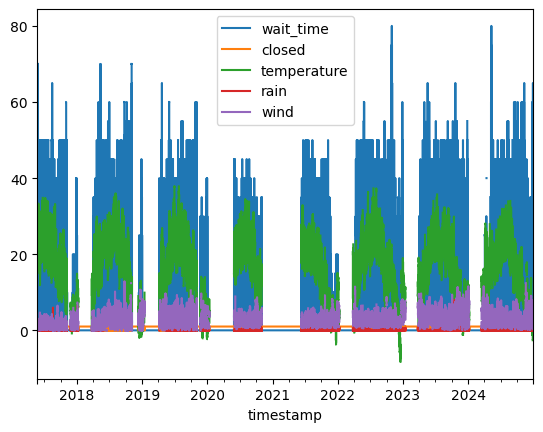

In [7]:
prophet_ride_df.plot(x="timestamp")

In [8]:
# cap wait times to 90 minutes
prophet_ride_df.loc[prophet_ride_df["wait_time"] > 90, "wait_time"] = 90

<Axes: xlabel='timestamp'>

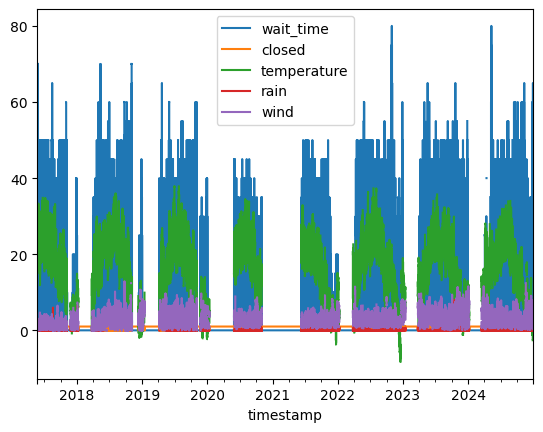

In [9]:
prophet_ride_df.plot(x="timestamp")

In [10]:
prophet_ride_df = prophet_ride_df.rename(columns={"timestamp": "ds", "wait_time": "y"})

prophet_ride_df

,ds,y,closed,temperature,rain,wind
0,2017-05-23 09:00:00,0.0,0,18.7,0.0,1.1
1,2017-05-23 09:30:00,10.0,0,18.7,0.0,1.1
2,2017-05-23 10:00:00,10.0,0,21.5,0.0,0.7
3,2017-05-23 10:30:00,25.0,0,21.5,0.0,0.7
4,2017-05-23 11:00:00,15.0,0,23.8,0.0,1.8
...,...,...,...,...,...,...
133412,2024-12-31 19:00:00,0.0,1,NaN,NaN,NaN
133413,2024-12-31 19:30:00,0.0,1,NaN,NaN,NaN
133414,2024-12-31 20:00:00,0.0,1,NaN,NaN,NaN
133415,2024-12-31 20:30:00,0.0,1,NaN,NaN,NaN


In [11]:
# Set weather data to 0 if the ride is closed
prophet_ride_df.loc[prophet_ride_df["closed"] == 1, "temperature"] = 0
prophet_ride_df.loc[prophet_ride_df["closed"] == 1, "rain"] = 0
prophet_ride_df.loc[prophet_ride_df["closed"] == 1, "wind"] = 0

# Forward fill the remaining NaN values
prophet_ride_df["temperature"] = prophet_ride_df["temperature"].ffill()
prophet_ride_df["rain"] = prophet_ride_df["rain"].ffill()
prophet_ride_df["wind"] = prophet_ride_df["wind"].ffill()

# Add transformed weather variables to capture non-linear relationships
prophet_ride_df['temp_squared'] = prophet_ride_df['temperature'] ** 2
prophet_ride_df['high_temp'] = (prophet_ride_df['temperature'] > 25).astype(int)
prophet_ride_df['any_rain'] = (prophet_ride_df['rain'] > 0).astype(int)
prophet_ride_df['high_wind'] = (prophet_ride_df['wind'] > 4).astype(int)

# Create interaction terms
prophet_ride_df['is_weekend'] = prophet_ride_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)
prophet_ride_df['temp_weekend'] = prophet_ride_df['temperature'] * prophet_ride_df['is_weekend']
prophet_ride_df['rain_weekend'] = prophet_ride_df['rain'] * prophet_ride_df['is_weekend']

prophet_ride_df

,ds,y,closed,temperature,rain,wind,temp_squared,high_temp,any_rain,high_wind,is_weekend,temp_weekend,rain_weekend
0,2017-05-23 09:00:00,0.0,0,18.7,0.0,1.1,349.69,0,0,0,0,0.0,0.0
1,2017-05-23 09:30:00,10.0,0,18.7,0.0,1.1,349.69,0,0,0,0,0.0,0.0
2,2017-05-23 10:00:00,10.0,0,21.5,0.0,0.7,462.25,0,0,0,0,0.0,0.0
3,2017-05-23 10:30:00,25.0,0,21.5,0.0,0.7,462.25,0,0,0,0,0.0,0.0
4,2017-05-23 11:00:00,15.0,0,23.8,0.0,1.8,566.44,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133412,2024-12-31 19:00:00,0.0,1,0.0,0.0,0.0,0.00,0,0,0,0,0.0,0.0
133413,2024-12-31 19:30:00,0.0,1,0.0,0.0,0.0,0.00,0,0,0,0,0.0,0.0
133414,2024-12-31 20:00:00,0.0,1,0.0,0.0,0.0,0.00,0,0,0,0,0.0,0.0
133415,2024-12-31 20:30:00,0.0,1,0.0,0.0,0.0,0.00,0,0,0,0,0.0,0.0


In [12]:
prophet_ride_df.isna().sum()

ds                 0
y               2247
closed             0
temperature        0
rain               0
wind               0
temp_squared       0
high_temp          0
any_rain           0
high_wind          0
is_weekend         0
temp_weekend       0
rain_weekend       0
dtype: int64

In [13]:
# create separate holidays df from the 'is_german_holiday', 'is_swiss_holiday', and 'is_french_holiday' columns
def create_country_holidays_df(data_df):
    swiss_holidays = data_df.loc[
        data_df["is_swiss_holiday"] == 1, ["timestamp"]
    ]
    swiss_holidays["ds"] = pd.to_datetime(swiss_holidays["timestamp"]).dt.date
    swiss_holidays = swiss_holidays.drop_duplicates(subset=["ds"])
    swiss_holidays = swiss_holidays.drop(columns=["timestamp"])
    swiss_holidays["holiday"] = "swiss_holiday"
    swiss_holidays["lower_window"] = 0
    swiss_holidays["upper_window"] = 0
    swiss_holidays = swiss_holidays.reset_index(drop=True)

    german_holidays = data_df.loc[
        data_df["is_german_holiday"] == 1, ["timestamp"]
    ]
    german_holidays["ds"] = pd.to_datetime(german_holidays["timestamp"]).dt.date
    german_holidays = german_holidays.drop_duplicates(subset=["ds"])
    german_holidays = german_holidays.drop(columns=["timestamp"])
    german_holidays["holiday"] = "german_holiday"
    german_holidays["lower_window"] = 0
    german_holidays["upper_window"] = 0
    german_holidays = german_holidays.reset_index(drop=True)


    french_holidays = data_df.loc[
        data_df["is_french_holiday"] == 1, ["timestamp"]
    ]
    french_holidays["ds"] = pd.to_datetime(french_holidays["timestamp"]).dt.date
    french_holidays = french_holidays.drop_duplicates(subset=["ds"])
    french_holidays = french_holidays.drop(columns=["timestamp"])
    french_holidays["holiday"] = "french_holiday"
    french_holidays["lower_window"] = 0
    french_holidays["upper_window"] = 0
    french_holidays = french_holidays.reset_index(drop=True)


    return swiss_holidays, german_holidays, french_holidays

swiss_holidays, german_holidays, french_holidays = create_country_holidays_df(ride_df)

In [14]:
# create df with covid lockdown dates
covid_lockdown_1_df = pd.DataFrame({
    'holiday': 'covid_lockdown_1',
    'ds': pd.date_range(start='2020-03-14', end='2020-05-29'),
    'lower_window': 0,
    'upper_window': 0
})

covid_lockdown_2_df = pd.DataFrame({
    'holiday': 'covid_lockdown_2',
    'ds': pd.date_range(start='2020-11-02', end='2021-05-20'),
    'lower_window': 0,
    'upper_window': 0
})

covid_recovery_df = pd.DataFrame({
    'holiday': 'covid_recovery',
    'ds': pd.date_range(start='2021-05-21', end='2021-07-31'),
    'lower_window': 0,
    'upper_window': 0
})

In [15]:
# define regular seasonal closures (Jan-Mar each year)
seasonal_closures = pd.DataFrame()
years = range(2017, 2024)  # All years in your dataset plus forecast year
for year in years:
    temp_df = pd.DataFrame({
        'holiday': 'seasonal_closure',
        'ds': pd.date_range(start=f'{year}-01-01', end=f'{year}-03-31'),
        'lower_window': 0,
        'upper_window': 0
    })
    seasonal_closures = pd.concat([seasonal_closures, temp_df])

seasonal_closures.head()

,holiday,ds,lower_window,upper_window
0,seasonal_closure,2017-01-01,0,0
1,seasonal_closure,2017-01-02,0,0
2,seasonal_closure,2017-01-03,0,0
3,seasonal_closure,2017-01-04,0,0
4,seasonal_closure,2017-01-05,0,0


In [16]:
all_holidays_df = pd.concat(
    [
        swiss_holidays,
        german_holidays,
        french_holidays,
        covid_lockdown_1_df,
        covid_lockdown_2_df,
        covid_recovery_df,
        seasonal_closures,
    ]
)

# set dtype to datetime
all_holidays_df["ds"] = pd.to_datetime(all_holidays_df["ds"])
all_holidays_df = all_holidays_df.sort_values(by=["ds"])
all_holidays_df = all_holidays_df.reset_index(drop=True)

all_holidays_df.head()

,ds,holiday,lower_window,upper_window
0,2017-01-01,seasonal_closure,0,0
1,2017-01-02,seasonal_closure,0,0
2,2017-01-03,seasonal_closure,0,0
3,2017-01-04,seasonal_closure,0,0
4,2017-01-05,seasonal_closure,0,0


In [17]:
prophet_ride_df = prophet_ride_df.sort_values(by="ds")
prophet_ride_df

,ds,y,closed,temperature,rain,wind,temp_squared,high_temp,any_rain,high_wind,is_weekend,temp_weekend,rain_weekend
0,2017-05-23 09:00:00,0.0,0,18.7,0.0,1.1,349.69,0,0,0,0,0.0,0.0
1,2017-05-23 09:30:00,10.0,0,18.7,0.0,1.1,349.69,0,0,0,0,0.0,0.0
2,2017-05-23 10:00:00,10.0,0,21.5,0.0,0.7,462.25,0,0,0,0,0.0,0.0
3,2017-05-23 10:30:00,25.0,0,21.5,0.0,0.7,462.25,0,0,0,0,0.0,0.0
4,2017-05-23 11:00:00,15.0,0,23.8,0.0,1.8,566.44,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133412,2024-12-31 19:00:00,0.0,1,0.0,0.0,0.0,0.00,0,0,0,0,0.0,0.0
133413,2024-12-31 19:30:00,0.0,1,0.0,0.0,0.0,0.00,0,0,0,0,0.0,0.0
133414,2024-12-31 20:00:00,0.0,1,0.0,0.0,0.0,0.00,0,0,0,0,0.0,0.0
133415,2024-12-31 20:30:00,0.0,1,0.0,0.0,0.0,0.00,0,0,0,0,0.0,0.0


In [18]:
train_prophet_df = prophet_ride_df.loc[(prophet_ride_df["ds"] < "2023-01-01")].reset_index()
val_prophet_df = prophet_ride_df.loc[(prophet_ride_df["ds"] >= "2023-01-01") & (prophet_ride_df["ds"] < "2024-01-01")].reset_index()

print(train_prophet_df.head(1))
print()
print(train_prophet_df.tail(1))
print()
print()
print(val_prophet_df.head(1))
print()
print(val_prophet_df.tail(1))

   index                  ds    y  closed  temperature  rain  wind  \
0      0 2017-05-23 09:00:00  0.0       0         18.7   0.0   1.1   

   temp_squared  high_temp  any_rain  high_wind  is_weekend  temp_weekend  \
0        349.69          0         0          0           0           0.0   

   rain_weekend  
0           0.0  

       index                  ds    y  closed  temperature  rain  wind  \
98333  98333 2022-12-31 23:30:00  0.0       1          0.0   0.0   0.0   

       temp_squared  high_temp  any_rain  high_wind  is_weekend  temp_weekend  \
98333           0.0          0         0          0           1           0.0   

       rain_weekend  
98333           0.0  


   index         ds    y  closed  temperature  rain  wind  temp_squared  \
0  98334 2023-01-01  0.0       1          0.0   0.0   0.0           0.0   

   high_temp  any_rain  high_wind  is_weekend  temp_weekend  rain_weekend  
0          0         0          0           1           0.0           0.0  

     

In [19]:
model = prophet.Prophet(
    # Core parameters
    seasonality_mode='multiplicative',  # Better for tourism/attraction data
    changepoint_prior_scale=0.05,       # Flexibility in trend changes
    changepoint_range=0.95,  # Allow changepoints closer to the end of the training data
    
    # Handling closures
    seasonality_prior_scale=12,         # Stronger seasonality influence
    yearly_seasonality=True,            # Capture yearly patterns
    weekly_seasonality=True,            # Capture weekly patterns
    daily_seasonality=12,               # Higher order for complex intraday patterns
    
    # Specific to park operation
    holidays_prior_scale=15,             # Strong holiday effects for parks,
    holidays=all_holidays_df,           # Include holidays and covid lockdowns
)

In [20]:
# Add ride closure status
model.add_regressor('closed', mode='additive', standardize=False)

# Add basic weather variables
model.add_regressor('temperature', mode='multiplicative', standardize=True)
model.add_regressor('rain', mode='multiplicative', standardize=True)
model.add_regressor('wind', mode='multiplicative', standardize=True)

# Add transformed variables as regressors
model.add_regressor('temp_squared', mode='additive', standardize=True)
model.add_regressor('high_temp', mode='multiplicative', standardize=False)
model.add_regressor('any_rain', mode='multiplicative', standardize=False)
model.add_regressor('high_wind', mode='multiplicative', standardize=False)
model.add_regressor('temp_weekend', mode='additive', standardize=True)
model.add_regressor('rain_weekend', mode='multiplicative', standardize=True)

In [21]:
model.fit(train_prophet_df)

18:21:58 - cmdstanpy - INFO - Chain [1] start processing
18:25:16 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future = model.make_future_dataframe(periods=int(365*24*(60 / 30)), freq="30min")
future.tail()

,ds
115849,2023-12-31 21:30:00
115850,2023-12-31 22:00:00
115851,2023-12-31 22:30:00
115852,2023-12-31 23:00:00
115853,2023-12-31 23:30:00


In [23]:
all_data_df = pd.concat([train_prophet_df, val_prophet_df], ignore_index=True)

future = future.merge(
    all_data_df[["ds", "closed", "temperature", "rain", "wind", "temp_squared", "high_temp", "any_rain", "high_wind", "temp_weekend", "rain_weekend"]],
    on="ds",
    how="left",
)
future = future.sort_values(by="ds")
future = future.reset_index(drop=True)

future.head()

,ds,closed,temperature,rain,wind,temp_squared,high_temp,any_rain,high_wind,temp_weekend,rain_weekend
0,2017-05-23 09:00:00,0,18.7,0.0,1.1,349.69,0,0,0,0.0,0.0
1,2017-05-23 09:30:00,0,18.7,0.0,1.1,349.69,0,0,0,0.0,0.0
2,2017-05-23 10:00:00,0,21.5,0.0,0.7,462.25,0,0,0,0.0,0.0
3,2017-05-23 10:30:00,0,21.5,0.0,0.7,462.25,0,0,0,0.0,0.0
4,2017-05-23 11:00:00,0,23.8,0.0,1.8,566.44,0,0,0,0.0,0.0


In [24]:
future.isna().sum()

ds              0
closed          0
temperature     0
rain            0
wind            0
temp_squared    0
high_temp       0
any_rain        0
high_wind       0
temp_weekend    0
rain_weekend    0
dtype: int64

In [25]:
forecast = model.predict(future)

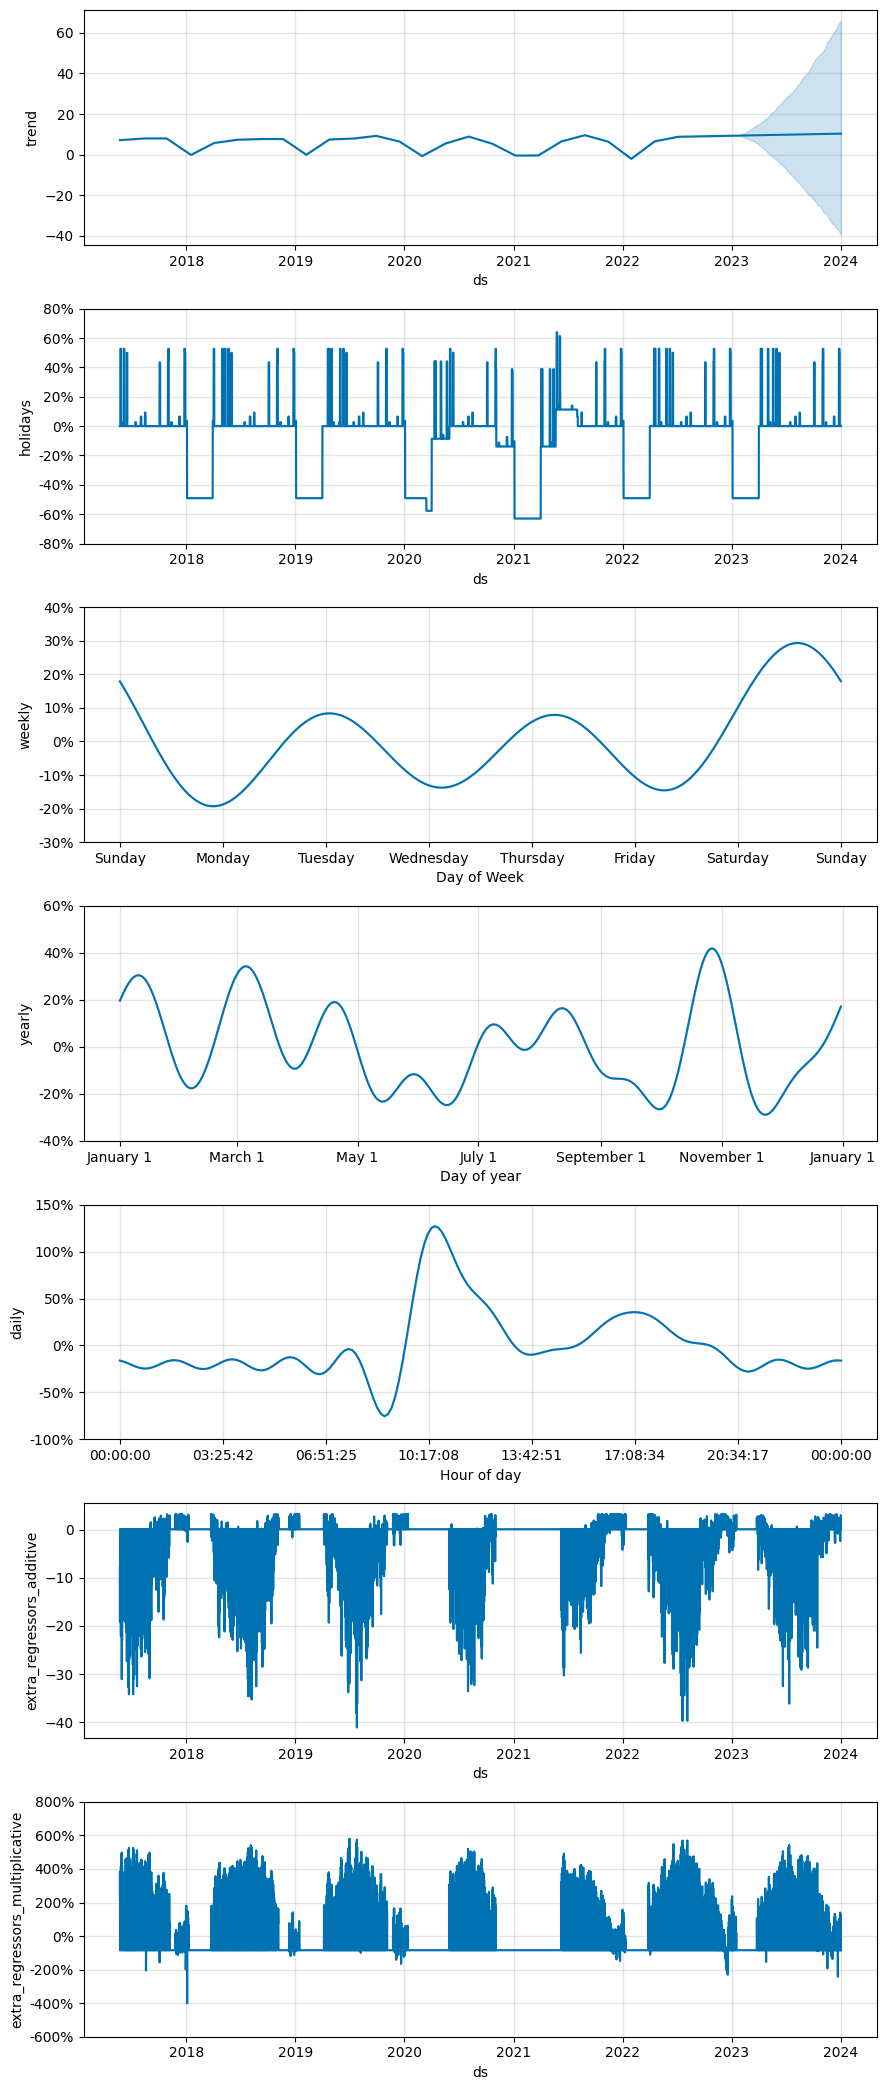

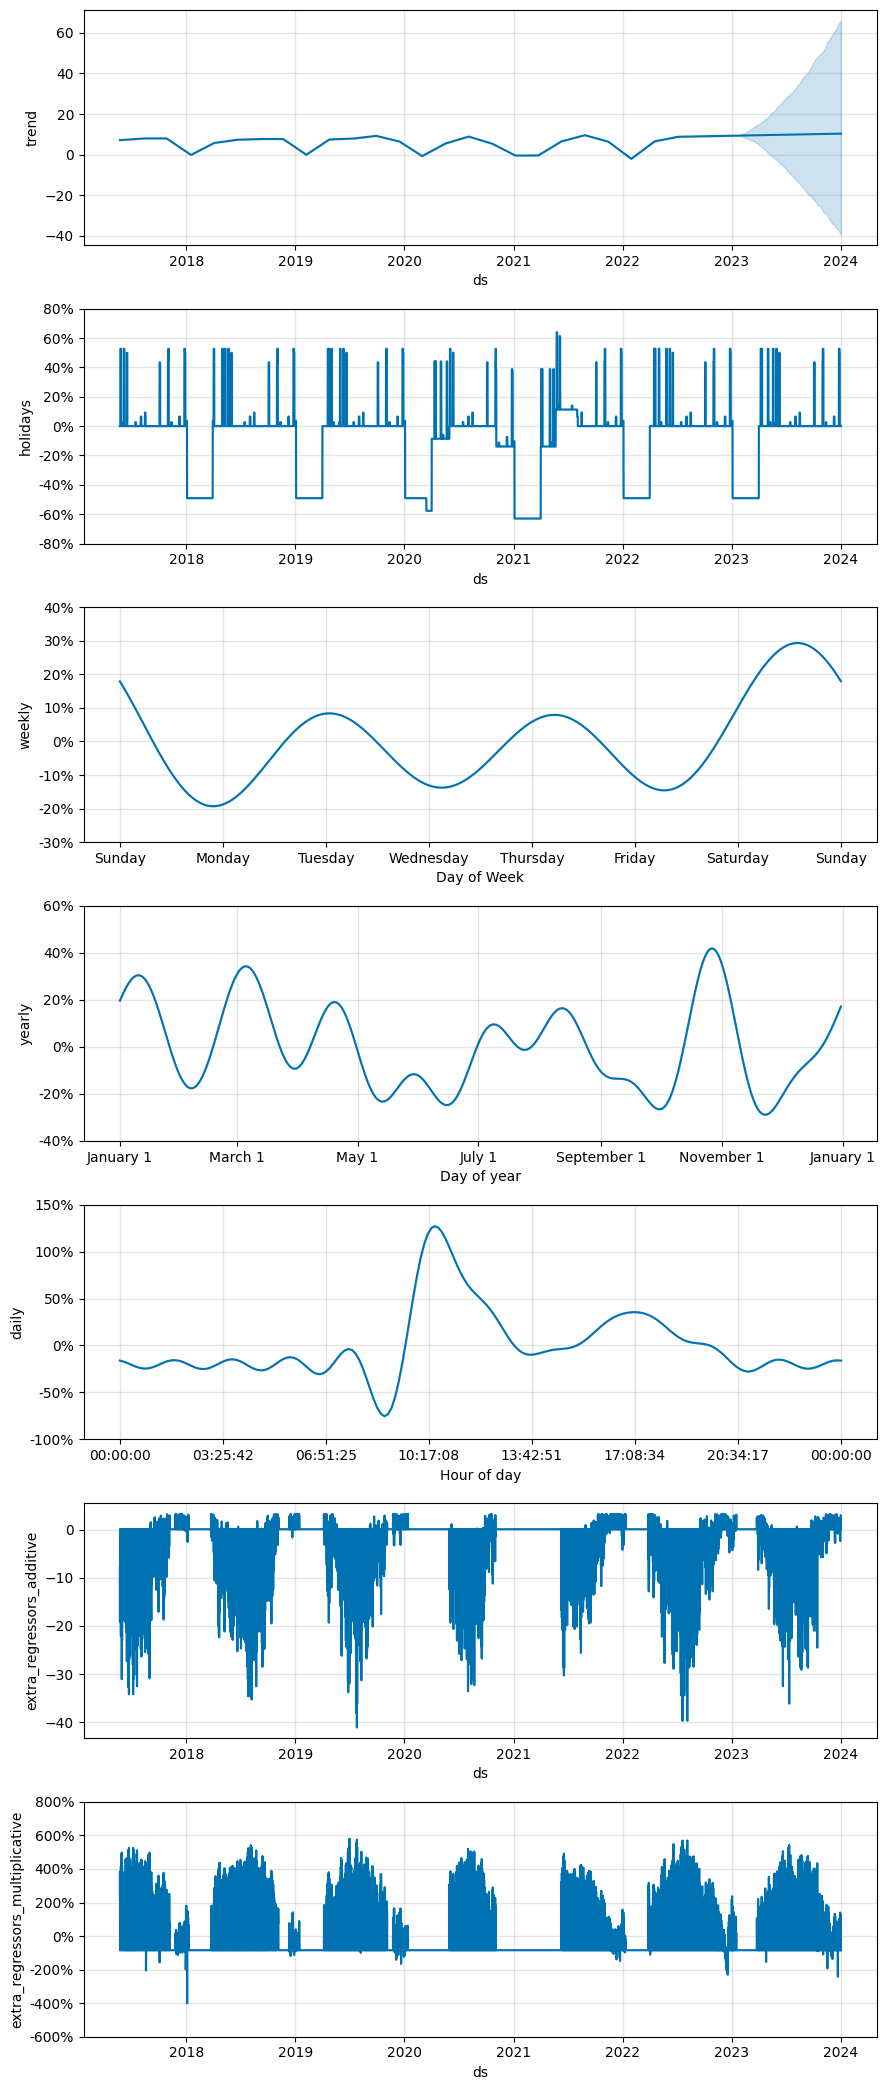

In [26]:
model.plot_components(forecast)

In [27]:
# Apply post-processing to correct systematic errors
def post_process_forecast(forecast, is_closed_data):
   # Force zero predictions during known closures
    closed_mask = forecast['ds'].isin(is_closed_data.loc[is_closed_data['closed'] == 1, 'ds'])
    forecast.loc[closed_mask, 'yhat'] = 0
    forecast.loc[closed_mask, 'yhat_lower'] = 0
    forecast.loc[closed_mask, 'yhat_upper'] = 0

    return forecast

forecast = post_process_forecast(forecast, future)

In [28]:
def make_verif(forecast, data_train, data_test): 
    """
    Put together the forecast (coming from fbprophet) 
    and the overved data, and set the index to be a proper datetime index, 
    for plotting

    Parameters
    ----------
    forecast : pandas.DataFrame 
        The pandas.DataFrame coming from the `forecast` method of a fbprophet 
        model. 
    
    data_train : pandas.DataFrame
        The training set, pandas.DataFrame

    data_test : pandas.DataFrame
        The training set, pandas.DataFrame
    
    Returns
    -------
    forecast : 
        The forecast DataFrane including the original observed data.

    """
    
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

In [29]:
verif = make_verif(forecast, train_prophet_df, val_prophet_df)

In [30]:
def plot_verif(verif, year):
    """
    plots the forecasts and observed data, the `year` argument is used to visualise 
    the division between the training and test sets. 

    Parameters
    ----------
    verif : pandas.DataFrame
        The `verif` DataFrame coming from the `make_verif` function in this package

    year : integer
        The year used to separate the training and test set. Default 2017

    Returns
    -------
    f : matplotlib Figure object

    """
    
    f, ax = plt.subplots(figsize=(14, 8))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(pd.Timestamp(f'{year}-01-01'), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

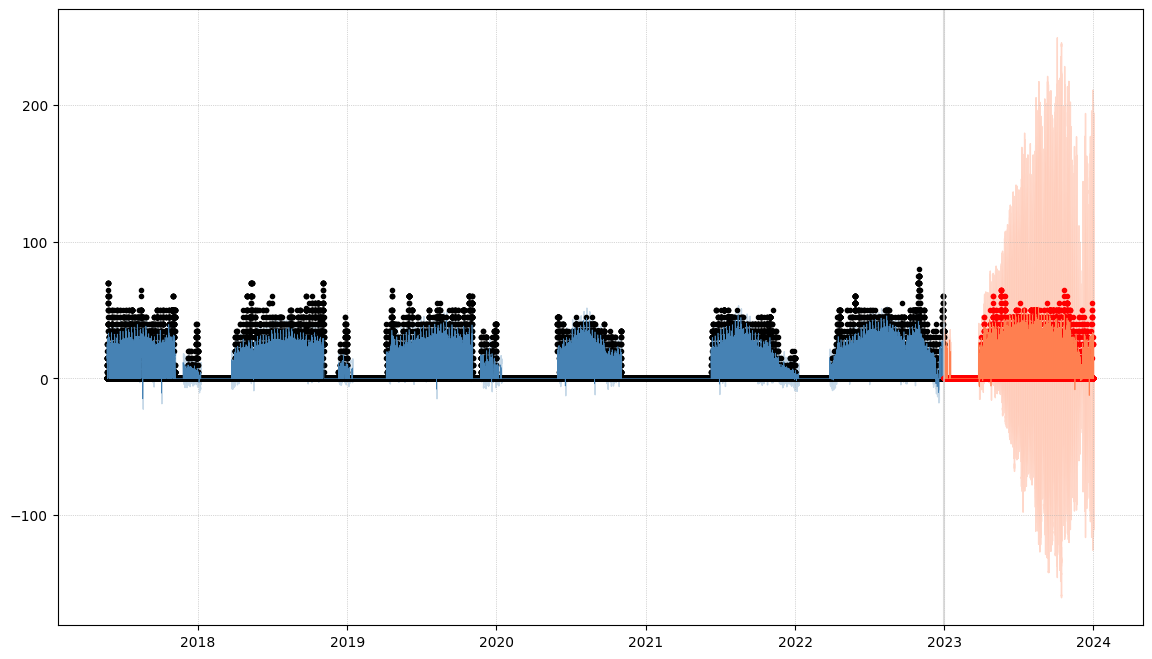

In [31]:
f = plot_verif(verif, year=2023)

In [32]:
def make_plot_block(verif, start_date, end_date, ax=None): 
    df = verif.loc[start_date:end_date,:]

    df.loc[:,'yhat'].plot(lw=2, ax=ax, color='r', ls='-', label='forecasts')
    
    ax.fill_between(df.index, df.loc[:,'yhat_lower'], df.loc[:,'yhat_upper'], color='coral', alpha=0.3)
    
    df.loc[:,'y'].plot(lw=2, ax=ax, color='steelblue', ls='-', label='observations')

    ax.grid(ls=':')
    ax.legend(fontsize=15)
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
    ax.set_ylabel('wait time', fontsize=15)
    ax.set_xlabel('', fontsize=15)

    ax.set_title(f'{start_date} to {end_date}', fontsize=18)

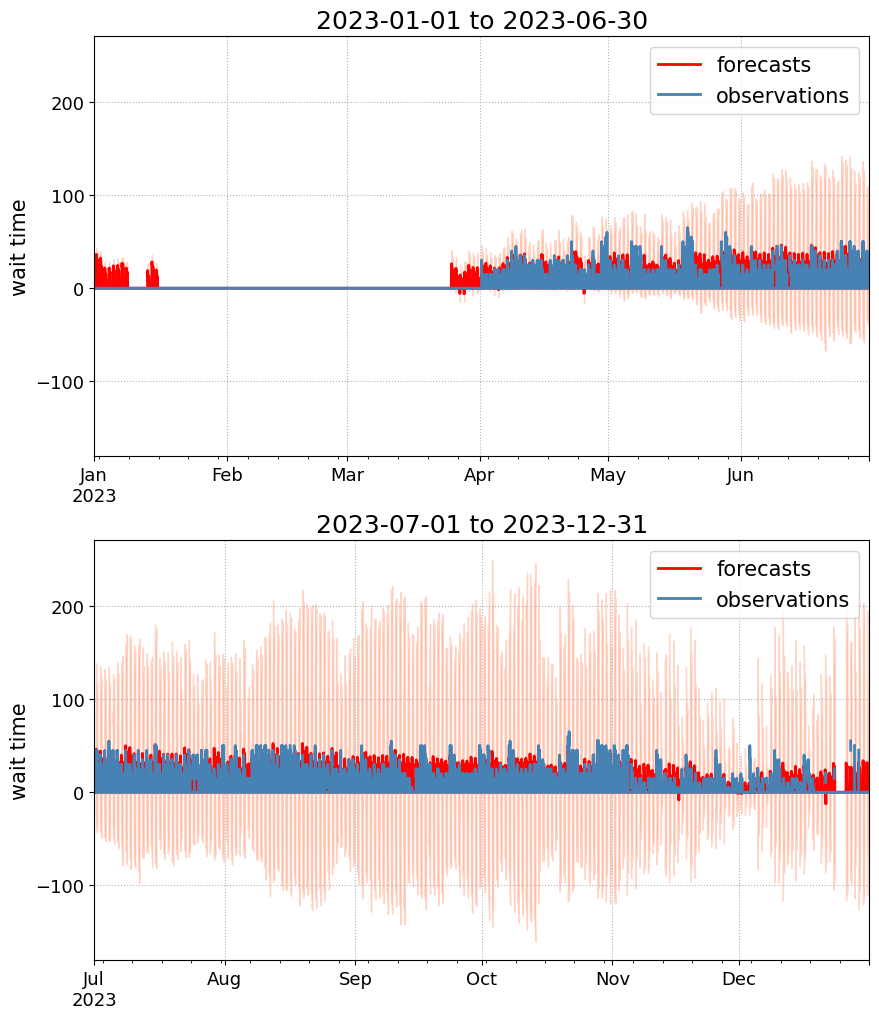

In [33]:
f, axes = plt.subplots(nrows=2, figsize=(10,12), sharey=True)

ax = axes[0]
make_plot_block(verif, '2023-01-01', '2023-06-30', ax=ax)

ax = axes[1]
make_plot_block(verif, '2023-07-01', '2023-12-31', ax=ax)

In [39]:
# Filter forecast to validation period
val_forecast = forecast[forecast['ds'].isin(val_prophet_df['ds'])]

# Only look at values where the ride is open
closed_mask = val_forecast['ds'].isin(future.loc[future['closed'] == 1, 'ds'])
val_forecast = val_forecast[~closed_mask]

# Get actual values, filtering to same indices as predictions
val_actual = val_prophet_df.set_index('ds').loc[val_forecast['ds'], 'y']
val_pred = val_forecast.set_index('ds')['yhat']

# Fill NaN values with 0
val_actual = val_actual.fillna(0)
val_pred = val_pred.fillna(0)

# Calculate error metrics
mae = mean_absolute_error(val_actual, val_pred)
rmse = np.sqrt(mean_squared_error(val_actual, val_pred))
mape = np.mean(np.abs((val_actual - val_pred) / (val_actual + 1e-5))) * 100

print(f"With Weather Variables:")
print(f"MAE (Mean Absolute Error): {mae:.2f} minutes")
print(f"RMSE (Root-Mean-Square Deviation): {rmse:.2f} minutes")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

With Weather Variables:
MAE (Mean Absolute Error): 10.64 minutes
RMSE (Root-Mean-Square Deviation): 12.81 minutes
MAPE (Mean Absolute Percentage Error): 21288977.98%
